In [1]:
import pandas as pd
import numpy as np

## .txt => DataFrame

In [2]:
def process_text(filename):
    texts = []
    with open('./mayfes/text_data/'+filename, 'r') as f:
        for line in f:
            texts.append(line[1:-2].replace(' ', '').split(','))
    df = pd.DataFrame(texts)
    if 2 in df.columns:
        drop_index = df.loc[df[2].notnull(), :].index
        df = df.drop(index=drop_index).reset_index(drop=True).rename(columns={0:'word', 1:filename.split('.')[0]})
    df = df.drop(index=df.loc[df['word'].str.match(r'^[a-zA-Z0-9_]+$')].index).reset_index(drop=True)
    df = df.drop(index=df.loc[df['word'].str.match(r'^[!-/:-@[-`{-~]+$')].index).reset_index(drop=True)
    return df.dropna(axis=1).reset_index(drop=True)
def make_univ_dfs(univ_name):
    types = ['noun']
    filenames = map(lambda tp: univ_name + '_' + tp + '.txt', types)
    dfs = list(map(process_text, filenames))
    return dict(zip(types, dfs))

In [14]:
ut_dict = make_univ_dfs('todai')
wa_dict = make_univ_dfs('waseda')
me_dict = make_univ_dfs('meiji')
ky_dict = make_univ_dfs('kyodai')
full_df = ut_dict['noun'].merge(wa_dict['noun'], on='word') .merge(me_dict['noun'], on='word').merge(ky_dict['noun'], on='word')
full_df['count'] = full_df['todai_noun'].astype(int) + full_df['waseda_noun'].astype(int) + full_df['meiji_noun'].astype(int) + full_df['kyodai_noun'].astype(int)
full_df.sort_values(by='count', ascending=False)[0:50]

,word,todai_noun,waseda_noun,meiji_noun,kyodai_noun,count
0,研究,299,239,62,298,898
1,情報,135,194,166,186,681
4,大学,103,93,157,194,547
9,学生,57,128,116,123,424
7,こと,69,80,73,154,376
6,教育,86,77,48,79,290
24,案内,39,74,96,64,273
3,年度,104,65,38,56,263
5,キャンパス,89,45,68,55,257
10,利用,56,69,30,101,256


## gensimでTF-IDFが計算できる形に変更

In [4]:
import functools
ut_words = list(map(lambda l: tuple(l), ut_dict['noun'].values))
wa_words = list(map(lambda l: tuple(l), wa_dict['noun'].values))
ky_words = list(map(lambda l: tuple(l), ky_dict['noun'].values))
me_words = list(map(lambda l: tuple(l), me_dict['noun'].values))
def num2words(univ_word):
    return [univ_word[0]] * int(univ_word[1])
ut_words = functools.reduce(lambda l1,l2: l1+l2, map(num2words, ut_words))
wa_words = functools.reduce(lambda l1,l2: l1+l2, map(num2words, wa_words))
ky_words = functools.reduce(lambda l1,l2: l1+l2, map(num2words, ky_words))
me_words = functools.reduce(lambda l1,l2: l1+l2, map(num2words, me_words))
full_words = [ut_words, wa_words, ky_words, me_words]

In [6]:
from gensim import corpora
from gensim import models
from operator import itemgetter
import functools
def ranking_by_tfidf(full_texts, target_words_list, n_extract=None):
    """
    tfidfによる対象の文書の単語ランキングを出力する。
    variables
    ----------
    full_texts: list(list(str))
    全文書の単語のlistが含まれているlist
    target_words_list: list(str)
    対象の文書の単語のlist
    n_extract: int
    第何位までランキングを出力するか？
    """
    dictionary = corpora.Dictionary(full_texts)
    id2token = {v: k for k, v in dictionary.token2id.items()}
    full_corpus = map(dictionary.doc2bow, full_texts)
    target_corpus = map(dictionary.doc2bow, [target_words_list])
    tfidf_model = models.TfidfModel(full_corpus)

    if n_extract is None:
        ranking_by_id = sorted(list(tfidf_model[target_corpus])[0], key=itemgetter(1), reverse=True)
    else:
        ranking_by_id = sorted(list(tfidf_model[target_corpus])[0], key=itemgetter(1), reverse=True)[0:n_extract]

    map_ranking = map(functools.partial(lambda id2token, tp: ((id2token[tp[0]], tp[1])), id2token), ranking_by_id)

    return list(map_ranking)

def ranking2df(ranking, column_names):
    return pd.DataFrame(list(zip(*ranking)) ,index=column_names).T

## TF-IDF値を.txtで出力

In [7]:
ut_top_tfidf = ranking_by_tfidf(full_words, ut_words)
ut_top_tfidf
# f = open('./tfidf_text/ut.txt', 'w')
# for x in ut_top_tfidf:
#     f.write(str(x) + "\n")
# f.close()

[('本郷', 0.4163118466732196),
 ('とうき', 0.2810104965044232),
 ('x˔', 0.27060270033759276),
 ('˔\x11', 0.27060270033759276),
 ('文京', 0.27060270033759276),
 ('休暇', 0.13530135016879638),
 ('短縮', 0.13530135016879638),
 ('小児', 0.1040779616683049),
 ('駒場', 0.10367101665804627),
 ('放射線', 0.0936701655014744),
 ('部局', 0.0936701655014744),
 ('x˔\x11', 0.08326236933464391),
 ('月曜', 0.08326236933464391),
 ('議院', 0.08326236933464391),
 ('臨床', 0.07991307534057734),
 ('ファイル', 0.07559344964649209),
 ('内分泌', 0.07285457316781344),
 ('内科', 0.07285457316781344),
 ('史料', 0.07285457316781344),
 ('完結', 0.07285457316781344),
 ('腎臓', 0.07285457316781344),
 ('財務', 0.0626345725642363),
 ('〆切', 0.06244677700098294),
 ('プロトコール', 0.06244677700098294),
 ('入院', 0.06244677700098294),
 ('患者', 0.06244677700098294),
 ('装置', 0.06244677700098294),
 ('関税', 0.06244677700098294),
 ('トーナメント', 0.05203898083415245),
 ('パーティー', 0.05203898083415245),
 ('一体', 0.05203898083415245),
 ('土日', 0.05203898083415245),
 ('小石川', 0.052038980834

In [8]:
me_top_tfidf = ranking_by_tfidf(full_words, me_words)
me_top_tfidf
# f = open('./tfidf_text/me.txt', 'w')
# for x in me_top_tfidf:
#     f.write(str(x) + "\n")
# f.close()

[('支部', 0.31634665670994894),
 ('駿河台', 0.1953905820855567),
 ('校友', 0.1721297985039428),
 ('厚吉', 0.16747764178762004),
 ('神田駿河台', 0.16747764178762004),
 ('明治大学', 0.15817332835497447),
 ('生田', 0.15817332835497447),
 ('Թ\x7f', 0.14421685820600613),
 ('\u05f8\x7f', 0.1302603880570378),
 ('和泉', 0.1302603880570378),
 ('紫紺', 0.12095607462439224),
 ('\x01Թ\x7f', 0.11165176119174669),
 ('リバティアカデミー', 0.11165176119174669),
 ('本校', 0.11165176119174669),
 ('杉原', 0.11165176119174669),
 ('早稲田大学', 0.09304313432645557),
 ('ドラマ', 0.09304313432645557),
 ('即日', 0.09304313432645557),
 ('明大', 0.09304313432645557),
 ('D\x16\u05f8\x7f', 0.08373882089381002),
 ('☆.', 0.08373882089381002),
 ('制服', 0.08373882089381002),
 ('急募', 0.08373882089381002),
 ('錯覚', 0.08373882089381002),
 ('御茶ノ水', 0.07908666417748723),
 ('京王', 0.07443450746116446),
 ('アカデミーコモン', 0.07443450746116446),
 ('司書', 0.07443450746116446),
 ('多摩', 0.07443450746116446),
 ('帝京平成大学', 0.07443450746116446),
 ('急行', 0.07443450746116446),
 ('虎ノ門', 0.074

In [9]:
ky_top_tfidf = ranking_by_tfidf(full_words, ky_words)
ky_top_tfidf 
# f = open('./tfidf_text/ky.txt', 'w')
# for x in ky_top_tfidf:
#     f.write(str(x) + "\n")
# f.close()

[('造形', 0.32690001684151065),
 ('三つ', 0.2964907129492771),
 ('左京', 0.25847908308398515),
 ('京都工芸繊維大学', 0.22806977919175161),
 ('エリッツ', 0.21286512724563483),
 ('イングリッシュ', 0.1748534973803429),
 ('協同', 0.1596488454342261),
 ('特性', 0.14824535647463855),
 ('スピード', 0.13684186751505095),
 ('登場', 0.13684186751505095),
 ('宇治', 0.12923954154199258),
 ('メダリスト', 0.11403488959587581),
 ('時計', 0.11403488959587581),
 ('お客様', 0.10643256362281742),
 ('吉田本', 0.10643256362281742),
 ('吉田', 0.09883023764975903),
 ('日本電産', 0.09883023764975903),
 ('永守', 0.09883023764975903),
 ('安否', 0.08362558570364226),
 ('岩倉', 0.08362558570364226),
 ('苦手', 0.08362558570364226),
 ('高木', 0.08362558570364226),
 ('スケート', 0.07602325973058387),
 ('コード', 0.07414838347317775),
 ('京大', 0.07222209674405468),
 ('構内', 0.06842093375752548),
 ('三条', 0.06842093375752548),
 ('北部', 0.06842093375752548),
 ('市内', 0.06842093375752548),
 ('使命', 0.06468263239149548),
 ('ファミリー', 0.06468263239149548),
 ('民主', 0.06152738203093472),
 ('追求', 0.06152

In [10]:
wa_top_tfidf = ranking_by_tfidf(full_words, wa_words)
wa_top_tfidf 
# f = open('./tfidf_text/wa.txt', 'w')
# for x in wa_top_tfidf:
#     f.write(str(x) + "\n")
# f.close()

[('早稲田', 0.6206613264823471),
 ('ӹ\x7f', 0.3906515407859479),
 ('校友', 0.22270788773778336),
 ('西早稲田', 0.1387360612137011),
 ('わせ', 0.13143416325508528),
 ('ハウス', 0.12413226529646942),
 ('\u05f8\x7f', 0.08762277550339018),
 ('江戸川橋', 0.07301897958615848),
 ('Թ\x7f', 0.06936803060685055),
 ('オフィシャル', 0.06571708162754264),
 ('オリジナル', 0.06571708162754264),
 ('大隈', 0.06571708162754264),
 ('電子', 0.06364179084339752),
 ('新宿', 0.060611229374664316),
 ('ジャーナル', 0.058415183668926784),
 ('作家', 0.058415183668926784),
 ('本庄', 0.058415183668926784),
 ('演劇', 0.058415183668926784),
 ('飲食', 0.058415183668926784),
 ('鳥獣', 0.058415183668926784),
 ('\x01Թ\x7f', 0.051113285710310936),
 ('\x16\u05f8', 0.051113285710310936),
 ('カレッジ', 0.051113285710310936),
 ('シンボル', 0.051113285710310936),
 ('ブリヂストン', 0.051113285710310936),
 ('ボディ', 0.051113285710310936),
 ('ユーザー', 0.051113285710310936),
 ('ロシア', 0.051113285710310936),
 ('委託', 0.051113285710310936),
 ('戸山', 0.051113285710310936),
 ('理工学部', 0.05111328571031093

## ネットワーク
日本語が現在出力できない

In [27]:
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#ネットワーク作成
def network(univ_name, top_tfidf, k):
    G = nx.Graph()
    nodes = []

    for tp in top_tfidf:
        nodes.append((univ_name, {'tfidf':1}))
        nodes.append((tp[0], {'tfidf':tp[1]}))
    G.add_nodes_from(nodes)
    for tp in top_tfidf:
        G.add_edge(univ_name, tp[0], weight= 1)
    #ネットワーク図描画
    plt.figure(figsize=(15,15))
    pos = nx.spring_layout(G,k=k)
    # node_size = [ d["count]*20 for (n,d) in G.nodes(data=True)]
    node_size = [ d["tfidf"]*100000 for (n,d) in G.nodes(data=True)]
    edge_width = [ d['weight']*20 for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color="r",alpha=0.6, node_size=node_size)
    nx.draw_networkx_labels(G, pos, font_family="IPAGothic", fontsize=10)
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='C', width=edge_width)

    plt.axis("off")
    plt.show()

/home/bearshu11/.anyenv/envs/pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/bearshu11/.anyenv/envs/pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


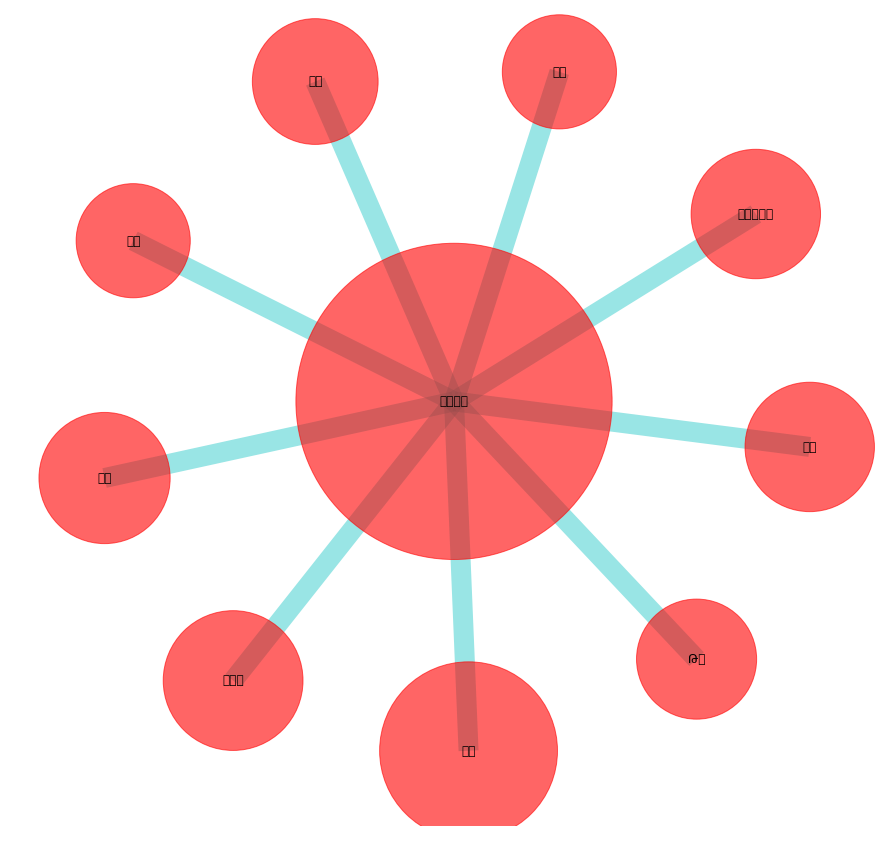

In [28]:
network('明治大学',ranking_by_tfidf(full_words, me_words)[0:10], 0.25)

## 以下試行錯誤

In [30]:
ut_df = pd.DataFrame(ut_texts)
ut_df

,0,1,2
0,研究,299,None
1,...,166,None
2,情報,135,None
3,平成,113,None
4,年度,104,None
5,大学,103,None
6,2018,95,None
7,キャンパス,89,None
8,教育,86,None
9,こと,69,None


In [29]:
ut_texts = []
with open('./mayfes/text_data/todai_noun.txt', 'r') as f:
    for line in f:
        ut_texts.append(line[1:-2].replace(' ', '').split(','))
ut_df = pd.DataFrame(ut_texts)
drop_index = ut_df.loc[ut_df[2].notnull(), :].index
ut_df.drop(index=drop_index).dropna(axis=1).reset_index(drop=True)

In [37]:
drop_index = ut_df.loc[ut_df[2].notnull(), :].index

In [41]:
ut_df.drop(index=drop_index).dropna(axis=1).reset_index(drop=True)

,0,1
0,研究,299
1,...,166
2,情報,135
3,平成,113
4,年度,104
5,大学,103
6,2018,95
7,キャンパス,89
8,教育,86
9,こと,69
